In [2]:
# # run only to verify the dataset read op
# import numpy as np
# import pandas as pd

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/intel-image-classification'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

2024-04-08 22:28:26.118808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 22:28:26.118957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 22:28:26.417279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version: 2.15.0


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.test.is_gpu_available()

True

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [8]:
data_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train/"
test_data_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test/"

num_classes = 6
img_width = 150
img_height = 150
batch_size = 64
seed = 1

In [9]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    seed=seed,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [10]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [11]:
val_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [12]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    seed=seed,
    shuffle=False,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 3000 images belonging to 6 classes.


In [13]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

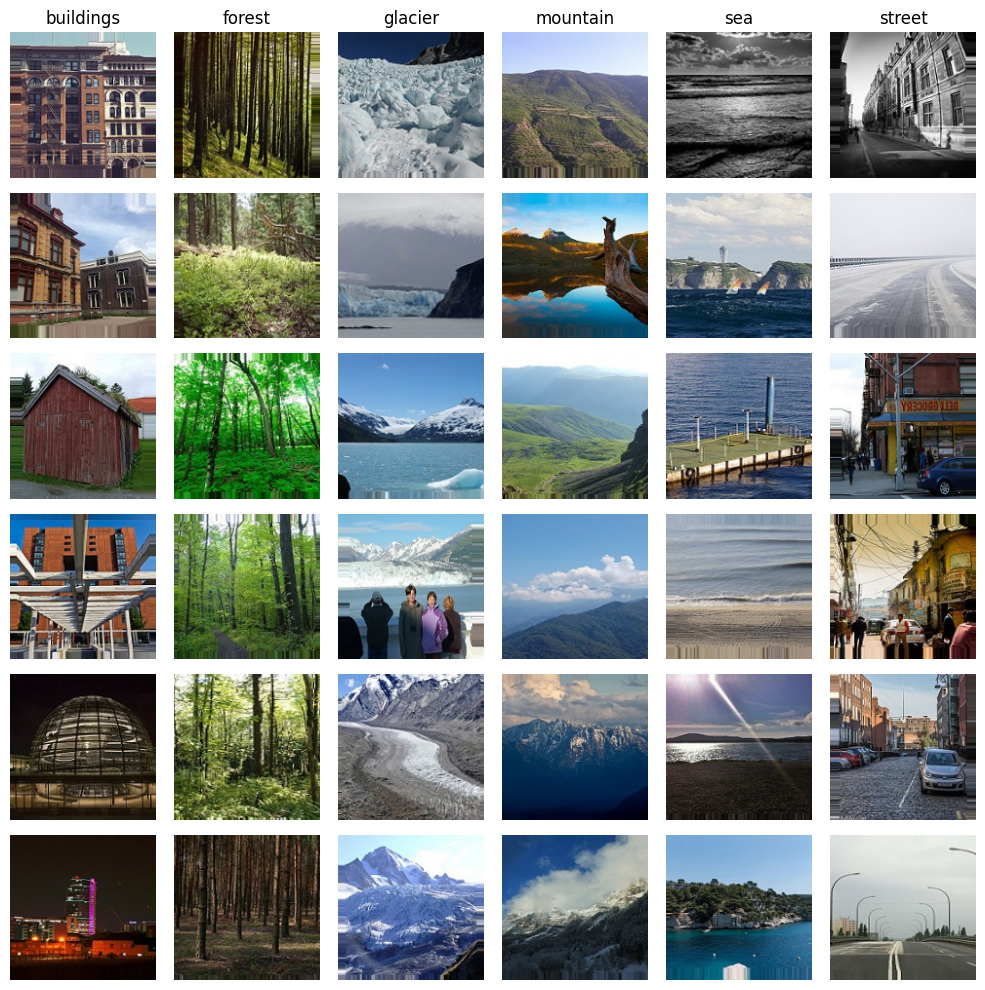

In [14]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(6, 6, figsize=(10, 10))

for i, class_label in enumerate(class_labels):
    images, _ = next(iter(train_generator))
    
    # Get indices of images belonging to the current class
    class_indices = np.where(np.argmax(_, axis=1) == i)[0]
    
    # Get random indices for selecting 6 images
    random_indices = np.random.choice(class_indices, 6, replace=False)
    
    for j, index in enumerate(random_indices):
        # Display the j-th randomly selected image of the current class in the corresponding subplot
        ax = axes[j, i]
        ax.imshow(images[index])
        ax.axis('off')
        if j == 0:
            ax.set_title(class_label)

plt.tight_layout()
plt.show()

# Commonly used function definitions

In [15]:
def plot_learning_curve(history_):
    training_loss = history_.history['loss']
    validation_loss = history_.history['val_loss']
    training_accuracy = history_.history['accuracy']
    validation_accuracy = history_.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
def evaluate_on_test_dataset(model_):
    test_loss, test_accuracy = model_.evaluate(test_generator)
    print(f'Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}')

In [17]:
# this test set is to find the worst classified example (without having to use the test_generator)
test_set = list()
for i in range(47):
    x_, y_ = test_generator[i]
    test_set.extend(zip(x_, y_))

In [18]:
def plot_worst_classified_examples(preds):    
    # Find misclassified examples
    worst_misclassifications = dict()
    for i, (x, y_true) in enumerate(test_set):
        pred_label = np.argmax(preds[i])
        true_label = np.argmax(y_true)
        if pred_label != true_label:
            prob_diff = preds[i][pred_label] - preds[i][true_label]
            if true_label not in worst_misclassifications:
                worst_misclassifications[true_label] = (x, prob_diff, pred_label)
            else:
                if worst_misclassifications[true_label][1] < prob_diff:
                    worst_misclassifications[true_label] = (x, prob_diff, pred_label)

#     # prints images 1 by 1
#     for key, value in worst_misclassifications.items():
#         true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
#         pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[1])
#         plt.imshow(value[0])
#         plt.title(f"True: {true_lbl}, Pred: {pred_lbl}")
#         plt.axis('off')
#         plt.show()
    
    # prints images as subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 10))
    for idx, (key, value) in enumerate(worst_misclassifications.items()):
        true_lbl = next(k for k, v in test_generator.class_indices.items() if v == key)
        pred_lbl = next(k for k, v in test_generator.class_indices.items() if v == value[2])
        
        r, c = (0, idx) if idx <= 2 else (1, idx-3)
        axs[r, c].imshow(value[0])
        axs[r, c].set_title(f"True: {true_lbl}, Pred: {pred_lbl}")
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

# 1. A simple CNN Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 52:03 18s/step - accuracy: 0.2188 - loss: 1.8044

I0000 00:00:1712609465.804761     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712609465.821764     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.4270 - loss: 1.4610

W0000 00:00:1712609607.415588     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.4284 - loss: 1.4575 - val_accuracy: 0.6680 - val_loss: 0.8715
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 562ms/step - accuracy: 0.7023 - loss: 0.8032 - val_accuracy: 0.7511 - val_loss: 0.6910
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 562ms/step - accuracy: 0.7418 - loss: 0.7027 - val_accuracy: 0.7892 - val_loss: 0.6019
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 143s 566ms/step - accuracy: 0.7827 - loss: 0.5891 - val_accuracy: 0.7700 - val_loss: 0.6333
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 562ms/step - accuracy: 0.8022 - loss: 0.5446 - val_accuracy: 0.8113 - val_loss: 0.5391
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 556ms/step - accuracy: 0.8269 - loss: 0.4884 - val_accuracy: 0.8231 - val_loss: 0.5021
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 555ms/step - accuracy: 0.8398 - loss: 0.4464 - val_accuracy: 0.8324 - val_loss: 0.4954
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 559ms/step - accuracy: 0.8453 - loss: 0.4300 

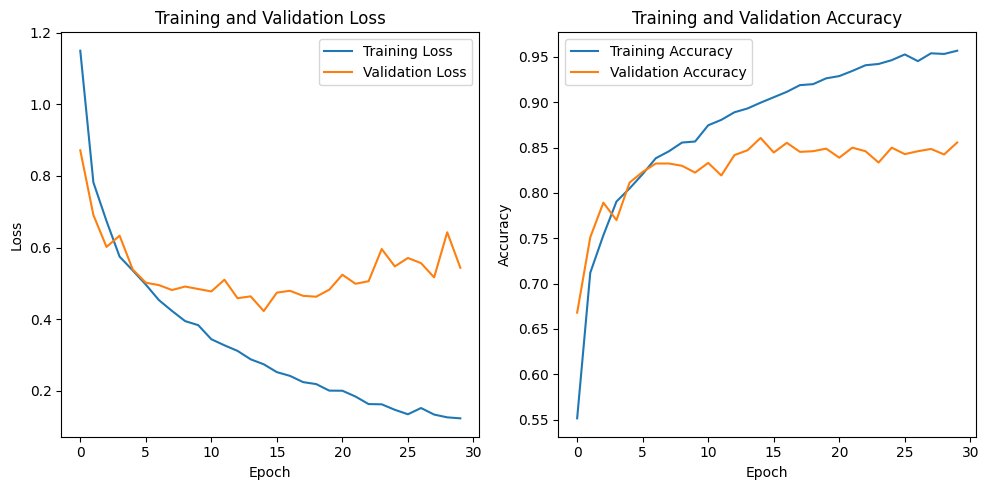

In [25]:
plot_learning_curve(history)

In [26]:
evaluate_on_test_dataset(model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 600ms/step - accuracy: 0.8497 - loss: 0.5642
Test Loss: 0.5916040539741516
Test Accuracy: 0.8420000076293945


W0000 00:00:1712612671.615973     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
predictions = model.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step 

W0000 00:00:1712612673.521568     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 490ms/step


W0000 00:00:1712612696.059183     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


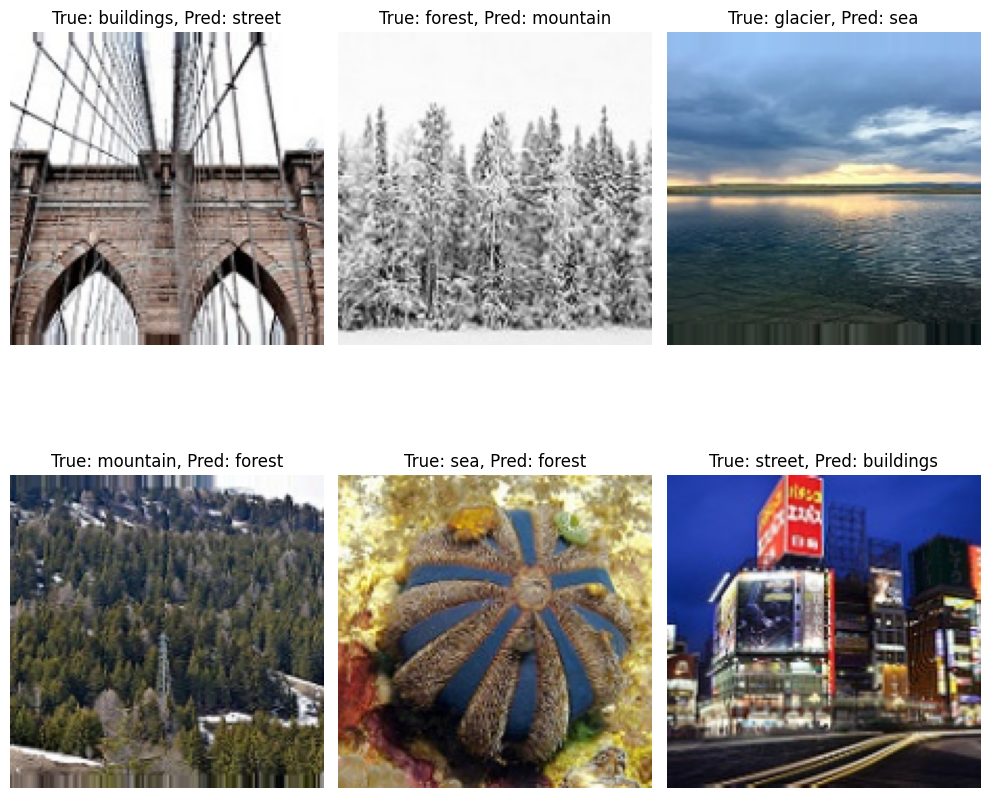

In [28]:
plot_worst_classified_examples(predictions)

# 2. A Model similar to Inception V3

In [23]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation

model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [24]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 146, 146, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 69, 69, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     7,373,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,661,606 (29.23 MB)

 Trainable params: 7,661,606 (29.23 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history2 = model2.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/176 ━━━━━━━━━━━━━━━━━━━━ 1:43:55 36s/step - accuracy: 0.0781 - loss: 1.7937

I0000 00:00:1712615485.507657     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712615485.529060     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/176 ━━━━━━━━━━━━━━━━━━━━ 7s 887ms/step - accuracy: 0.4466 - loss: 1.3389

W0000 00:00:1712615632.774122     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.4508 - loss: 1.3302

W0000 00:00:1712615637.283602     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.4513 - loss: 1.3293 - val_accuracy: 0.6537 - val_loss: 0.8925
Epoch 2/30


W0000 00:00:1712615678.574963     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 558ms/step - accuracy: 0.6206 - loss: 0.9544 - val_accuracy: 0.6437 - val_loss: 0.8677
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 564ms/step - accuracy: 0.6709 - loss: 0.8521 - val_accuracy: 0.7336 - val_loss: 0.7173
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 564ms/step - accuracy: 0.7039 - loss: 0.7849 - val_accuracy: 0.7225 - val_loss: 0.7266
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 564ms/step - accuracy: 0.7169 - loss: 0.7309 - val_accuracy: 0.7464 - val_loss: 0.6864
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 101s 557ms/step - accuracy: 0.7593 - loss: 0.6626 - val_accuracy: 0.7732 - val_loss: 0.6252
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 559ms/step - accuracy: 0.7729 - loss: 0.6112 - val_accuracy: 0.7953 - val_loss: 0.5244
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 103s 564ms/step - accuracy: 0.7973 - loss: 0.5596 - val_accuracy: 0.8039 - val_loss: 0.5441
Epoch 9/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 559ms/step - accuracy: 0.8075 - loss: 0.53

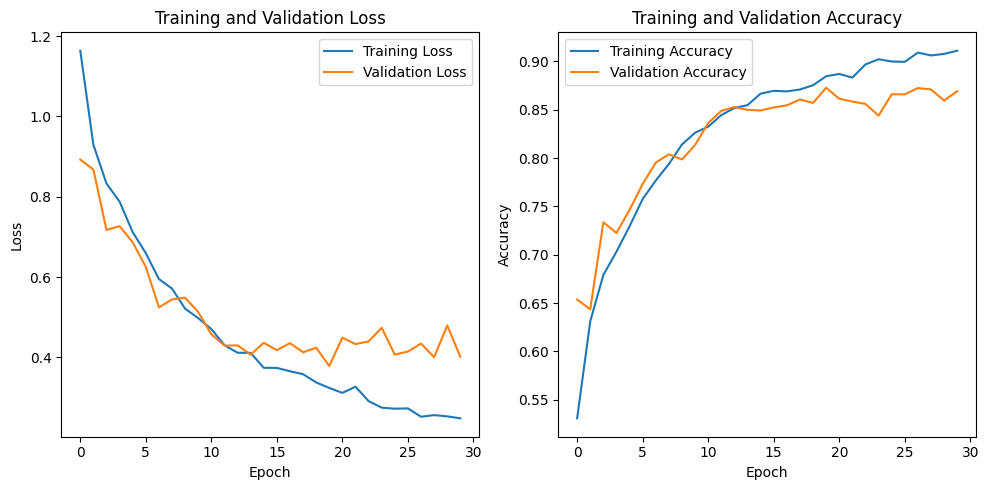

In [28]:
plot_learning_curve(history2)

In [29]:
evaluate_on_test_dataset(model2)

47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.8806 - loss: 0.3808
Test Loss: 0.4436355233192444
Test Accuracy: 0.859666645526886


W0000 00:00:1712618655.496412     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [30]:
predictions2 = model2.predict(test_generator)

 2/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step  

W0000 00:00:1712618657.318952     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 450ms/step


W0000 00:00:1712618678.000599     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


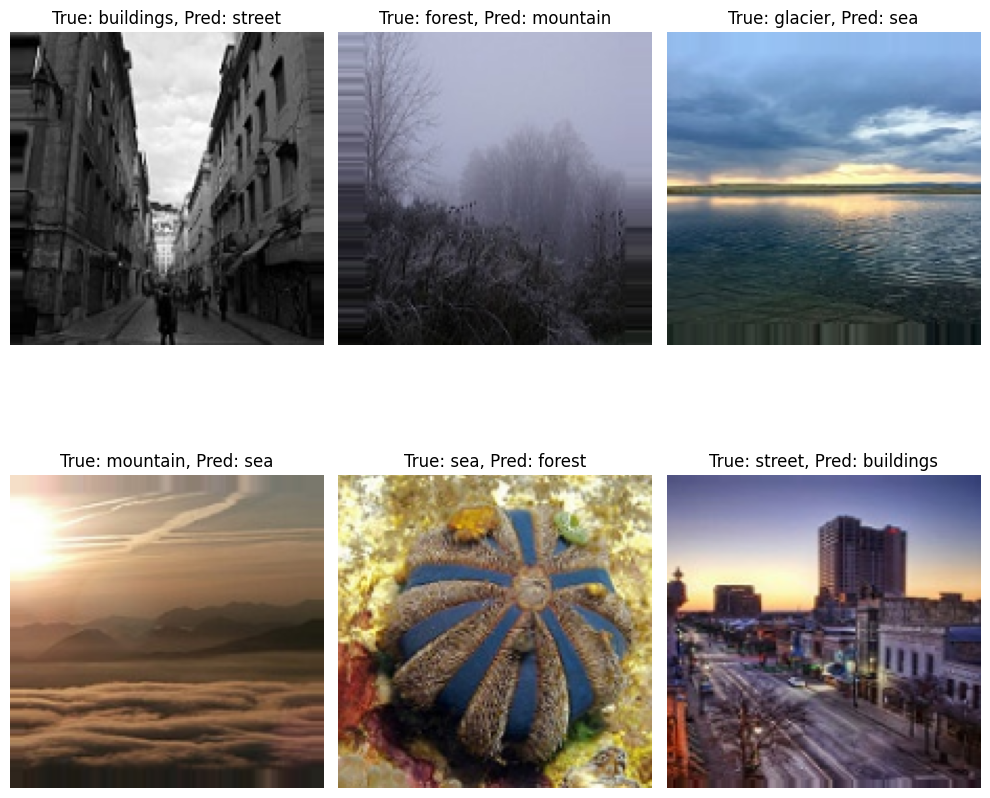

In [31]:
plot_worst_classified_examples(predictions2)